## Legendre Polynomials 

_CYBR 304 & MATH 420_ <br>
_Spring 2024_ <br>

In this notebook, we'll examine several ways to numerically evaluate the Legendre polynomials. Our first three methods use the Bonnet recursion. Specifically, the Bonnet recursion for the Legendre polynomials is  $(n+1) P_{n+1}(x) = (2n+1) x P_n(x) - n P_{n-1}(x)$, with $P_0(x) = 1$ and $P_1(x) = x$. 

The first version is purely recursive. This code is easy to write, but we'll show that it is terribly inefficient. Our second method also uses the Bonnet recursion, but it uses a dictionary to memoize values to gain efficiency. Our third method uses the Bonnet recursion, but it is iterative. 
Additionally, we'll examine several methods that do not explicitly use the Bonnet recursion.

We would like for our function to return a number with the same type as the input. Getting this to work for all floating point inputs (Float16, Float32, Float64, and BigFloat), doesn't take special attention, but the case of an integer input does. Actually when the input `x` is an integer, we would like our code to return a rational number, but this case is tricky because but Julia's `/` operator returns a float for integer divison, not a rational number. To resolve this, we'll use multiple dispatch to handle the case when `x` is an integer. The special case will convert the integer input to a rational.

In [2]:
"""
    legendre_poly(n::Integer, x::Number)::Number

Compute the nth degree Legendre polynomial evaluated at `x`. Unless the input `x` is an integer or a complex integer, the return value has the same 
type as the input `x`. When the input `x` is an integer or a complex integer, the number `x` is promoted to a rational type.

##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 
"""
function legendre_poly(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    if n == 0 
       one(x)
    elseif n == 1
       x
    else # use the Bonnet recursion http://dlmf.nist.gov/18.9.E2
       ((2*n - 1)*x*legendre_poly(n - 1, x) - (n - 1)*legendre_poly(n - 2, x))/n
    end
end;

In [3]:
# When `x` is an integer, convert `x` to a rational and dispatch legendre_poly.
function legendre_poly(n::Integer, x::Integer)
    legendre_poly(n, convert(Rational, x))
end;

Does our docstring work? Let's test it

In [5]:
? legendre_poly

search: legendre_poly



```
legendre_poly(n::Integer, x::Number)::Number
```

Compute the nth degree Legendre polynomial evaluated at `x`. Unless the input `x` is an integer or a complex integer, the return value has the same  type as the input `x`. When the input `x` is an integer or a complex integer, the number `x` is promoted to a rational type.

##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 


Let's do a simple test. We'll use an explicit representation for the order five Legendre polynomial to graph the difference between the explicit representation and the value given by our code. The explicit representation is
$$
  P_5(x) = \frac{1}{8} \left(63x^5-70x^3+15x\right)
$$
We'll use the Julia macro `@evalpoly` for evaluation of the explicit formula for $P_5$.

In [7]:
P5 = x -> @evalpoly(x,0, 15/8, 0, -35/4, 0, 63/8);

In [8]:
using Gadfly
my_palette = ["#800080", "#8A2BE2"];

Here we graph the absolute difference between the value of $P5(x)$ and $\mathrm{legendre\_poly}(5, x)$ divided by the `Float64` machine epsilon. The graph indicates that the greatest absolute difference is about 8 times the machine epsilon on the interval $[-1,1]$. The greatest absolute differences are near -1 and 1. 

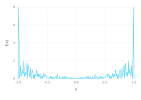

In [10]:
plot(x -> abs(legendre_poly(5, x)-P5(x))/eps(Float64),-1, 1)

Let's define a modified log base two of a relative difference `LRE`. The range of this graph appears to be about $[45,53]$. So again, we have good agreement between these functions.

In [12]:
function LRE(a,b)
    d = abs(a-b)
    if iszero(d)
        precision(a)
    elseif iszero(a)
        min(precision(a), -log2(a))
    else
        min(precision(a), -log2(abs(d/b)))
    end
end

LRE (generic function with 1 method)

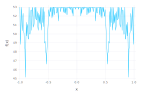

In [13]:
plot(x -> LRE(legendre_poly(5, x),P5(x)),-1, 1)

Let's test the claim that the return type is the same as the input. Here is a function that does the testing:

In [15]:
function test_types(n::Integer,x::Real, fn::Function)
    L = [Float16, Float32, Float64, BigFloat, Rational{BigInt}, 
        Complex{Float16}, Complex{Float32}, Complex{Float64}, Complex{BigFloat}, Complex{Rational{BigInt}}]
    OK = true
    for lk in L
        OK = OK && typeof(fn(n, convert(lk, x))) == lk
    end
    OK
end

test_types (generic function with 1 method)

In [16]:
test_types(0,0.23,legendre_poly), test_types(1,0.23,legendre_poly), test_types(10,0.23,legendre_poly)

(true, true, true)

In [17]:
using BenchmarkTools

In [18]:
@btime legendre_poly(2, 0.23)

  11.011 ns (0 allocations: 0 bytes)


-0.42064999999999997

In [19]:
@btime legendre_poly(4, 0.23)

  40.969 ns (0 allocations: 0 bytes)


0.18886804374999996

In [20]:
@btime legendre_poly(8, 0.23)

  374.634 ns (0 allocations: 0 bytes)


-0.10928775530968499

In [21]:
@btime legendre_poly(16, 0.23)

  18.400 μs (0 allocations: 0 bytes)


-0.1535942313757027

The reason for this inefficiency is fairly apparent. The recusion involves a great deal of redundant work. Specifically, a recursion for the number of floating point operations needed to compute the nth degree Legendre polynomial this way
is
$$
   C_n = C_{n-1} + C_{n-2} + 5, \quad C_0 = 0, C_1 = 1.
$$
The reason for the $+5$ is that once the recursive call has evaluated both `legendre_poly(n - 1, x)` and  `legendre_poly(n - 2, x))`, there are
five additional floating point operations needed to evaluate `((2*n - 1)*x*legendre_poly(n - 1, x) - (n - 1)*legendre_poly(n - 2, x))//n`

It's not too hard to show that an explicit formula for $C$ is 
$$
   C_k = 5 \, \mathrm{Fib}_k - 5,
$$
where $\mathrm{Fib}$ is the Fibonacci sequence. From this, it follows that $C_n \approx \sqrt{5} \times \left(\frac{1+\sqrt{5}}{2} \right)^n$, so
$C$ has exponential growth.

To make this code more efficient, we could either convert the function to be a memoizing function or write it as a purely iterative fashion. 

First, let's try a memoizing function. Julia does have a macro that converts any function into a memoizing function. There is a Julia macro that will
effortlessly convert our function into a memoizing function, but let's do it our selves (DIY).  An advantage to this DIY project is that we can delete keys that we no longer need. Doing so helps reduce the size of the dictionary (hash table). The Julia macro approach does not give us a way to delete keys that are no longer needed.

In [23]:
"""
    P(n::Integer, x::Number, dict = Dict(0 => one(x), 1 => x))::Number

    Compute the nth degree Legendre polynomial evaluated at x. The value returned has the same type as the input `x`.  
    
##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 
"""
function P(n::Integer, x::Number)
    dict = Dict{Int, Number}(0 => one(x), 1 => x)
    function compute_P(n, x, dict) 
        if n in keys(dict)
            if n >= 2
                delete!(dict, n-1)
            end
            dict[n]
        else
            dict[n] = ((2*n - 1)*x*compute_P(n - 1, x, dict) - (n - 1)*compute_P(n - 2, x, dict)) / n
        end
    end
    n >= 0 || throw(ArgumentError("The first argument to P must be a nonnegative integer; found $n"))
    compute_P(n, x, dict)
end;

Similar to our first method, the type returned should match the type of the input. 
Does it?

In [25]:
test_types(0,0.46, P), test_types(1,0.46, P),test_types(10,0.46, P)

(true, true, true)

Let's test if our new and old versions agree. Algorithmically, these functions are the same, so a graph of the difference `P(25,x) - legendre_poly(25,x)` should be zero; it is

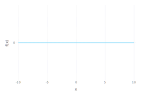

In [27]:
plot(x -> (P(5,x) - legendre_poly(5,x)),-10,10)

And let's check that the new function is more efficient. For a degree 25 Legendre polynomial, the new code is about 200 times faster!

In [29]:
z1 = @btime P(25,0.23)

  6.920 μs (202 allocations: 3.62 KiB)


-0.05702283068726503

In [30]:
z2 = @btime legendre_poly(25,0.23)

  1.406 ms (0 allocations: 0 bytes)


-0.05702283068726503

In [31]:
P(15000,0.1)

LoadError: StackOverflowError:

In [32]:
"""
    legendre_poly(n::Integer, x::Number)::Number

Compute the nth degree Legendre polynomial evaluated at `x`. Unless the input `x` is an integer or a complex integer, the return value has the same 
type as the input `x`. When the input `x` is an integer or a complex integer, the number `x` is promoted to a rational type.

##### Error:

-The degree `n` must be a nonnegative integer; if not, throw an `ArgumentError`.

##### Details

-For information on Legendre polynomials, refer to DLMF Section 18.3, https://dlmf.nist.gov/18.3 . 
"""
function legendre_poly(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)/k)
        end
        p1
    end
end;

In [33]:
z1 = @btime P(10^3,0.23)

  311.400 μs (10480 allocations: 168.91 KiB)


0.02454507368238845

In [34]:
z2 = @btime legendre_poly(10^3,0.23)

  7.025 μs (0 allocations: 0 bytes)


0.02454507368238845

Let's compare the explicit formula for the 5th order Legendre polynomial to the new code.


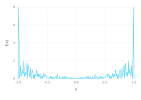

In [36]:
plot(x -> abs(legendre_poly(5, x)-P5(x))/eps(Float64),-1, 1)

The claim is that except for integer inputs, the type of the output is the same as the input `x`. This passes some simple tests:

In [38]:
test_types(0,0.128,legendre_poly),test_types(1,0.128,legendre_poly),test_types(10,0.128,legendre_poly),test_types(0, BigInt(2)//9,legendre_poly)

(true, true, true, true)

Unfortunately, for large degree the code can overflow, and subtraction in `(p1, ((2*k - 1)*x*p1 - (k - 1)*p0) / k)` gives `NaN`. An example

In [40]:
legendre_poly(5000, -1.018)

NaN

Evaluating with `BigFloat` numbers, we see that a better value is `InF`, not  `NaN`:

In [42]:
legendre_poly(5000, BigFloat(-1.018))

3.507125816773159960579868905776330855360801710615406803241746151525299693053747e+409

In [43]:
function legendre_poly(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)/k)
        end
        if isnan(p1) throw(ArgumentError("Floating point overflow evaluating legendre_poly($n, $x)")) else p1 end
    end
end;

One simple test:

In [45]:
legendre_poly(5000, -1.018)

LoadError: ArgumentError: Floating point overflow evaluating legendre_poly(5000, -1.018)

What about accuracy? Should we trust every digit? Of course not. Here is an example where the last five digits of a Float64 value are not correct. To find the exact value, we use rational arithmetic to find the value.

In [47]:
(n,x) = (5000, -63/64);

In [48]:
xFloat64 = legendre_poly(n,x)

-0.0004553305753125159

In [49]:
xBig = convert(Float64, legendre_poly(n, convert(Rational{BigInt},x)))

-0.0004553305753136357

The relative difference is about $10^{-12}$.

In [51]:
(xFloat64 - xBig)/xBig

-2.4593521159441414e-12

What's the story? The subtraction in `((2*k - 1)*x*p1 - (k - 1)*p0) / k)` can be mildly ill-conditioned. One way to possibly reduce the rounding error in evaluating `((2*k - 1)*x*p1 - (k - 1)*p0) / k)` is to distrubute the division over the sum and evaluate ``((2*k - 1)*x*p1 / k - (k - 1)*p0 / k)`. A worst case upper bound for the floating point rounding gives
$$
\mathcal{E}_1 = \left | ((2k-1) \otimes x \otimes p_1 - (k-1) \otimes p_0) \oslash k - ((2k-1) x p_1 - (k-1) p_0)/k \right|
\leq 2 \epsilon_m \left | \frac{(2k-1) p_1 x}{k} \right | + \epsilon_m \left | \frac{(k-1) p_0}{k} \right |
  + 2 \epsilon_m \left |  \frac{(2k-1) p_1 x}{k}  - \frac{(k-1) p_0}{k} \right |,
$$
and
$$
\mathcal{E}_2 = \left | ((2k-1) \otimes x \otimes p_1  \oslash k - (k-1) \otimes p_0 \oslash k - ((2k-1) x p_1 - (k-1) p_0)/k \right|
\leq 3 \epsilon_m \left | \frac{(2k-1) p_1 x}{k} \right | + 2 \epsilon_m \left | \frac{(k-1) p_0}{k} \right |
  + \epsilon_m \left |  \frac{(2k-1) p_1 x}{k}  - \frac{(k-1) p_0}{k} \right |,
$$
where $ \epsilon_m$ is the machine epsilon. Subtraction of the upper bounds for $\mathcal{E}_1$ and $\mathcal{E}_2$, shows that the upper bound for
$\mathcal{E}_2$ is smaller then the upper bound for $\mathcal{E}_1$.


So let's take a small preformace decrease and write our code as

In [53]:
function legendre_polyX(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, ((2*k - 1)*x*p1/k  - (k - 1)*p0/k))
        end
        if isnan(p1) throw(ArgumentError("Floating point overflow evaluating legendre_poly($n, $x)")) else p1 end
    end
end;

Do we win? We'll try one example. For this example, we do indeed win. We've modestly reduced the relative error from about $2.5 \times 10^{-12}$ to
about $1.3 \times 10^{-12}$.

In [55]:
xFloat64 = legendre_polyX(n,x)

-0.0004553305753142306

In [56]:
(xFloat64 - xBig)/xBig

1.3065270910766815e-12

In [57]:
plot(x -> accuracy_test(legendre_polyX,16,x) / accuracy_test(legendre_poly,16,x),-2,2)

Plot(...)

In [58]:
using LegendrePolynomials

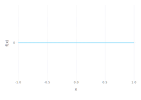

In [59]:
plot(x -> (legendre_poly(128, x) - Pl(x,128))/eps(Float64),-1,1)

Speedwise, the methods seem to be about the same

In [61]:
(n,x) = (5000, 0.75)

(5000, 0.75)

In [62]:
@btime legendre_poly(n,x)

  35.600 μs (1 allocation: 16 bytes)


0.012692432195343313

In [63]:
@btime Pl(x,n)

  35.600 μs (1 allocation: 16 bytes)


0.012692432195343313

For a more detailed view of the accuracy, we can compare to values determined by exact rational arithmetic.

In [65]:
function accuracy_test(fn, n,x)
    y1 = fn(n,x)
    y2 = legendre_poly(n, convert(Rational{BigInt},x))    
    LRE(y1,y2)    
end

accuracy_test (generic function with 1 method)

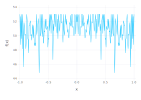

In [66]:
plot(x -> accuracy_test(legendre_poly, 32,x),-1,1)

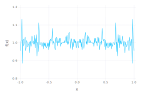

In [67]:
plot([x -> accuracy_test(legendre_polyX, 10,x)/accuracy_test(legendre_poly, 10,x)], -1,1)

In [68]:
"""
    KahanSum(a...)

Return the Kahan summation of a sequence of numbers `a::Vararg`. 

For more details about this method, see [Wikipedia](https://en.wikipedia.org/wiki/Kahan_summation_algorithm).

# Arguments
- `a::Vararg` Sequence of numbers to be summed.

# Returns
- The sum of the input numbers computed using Kahan summation. The return type is
  `eltype(a)'

# Error
Throw an `ArgumentError` when the argument `a` is empty.

# Example
```julia
KahanSum(1.0, 2.0, 3.0)
6.0

KahanSum(2//3, 6.7, BigFloat(5.6))
12.9666666666666667850904559600166976451873779296875
"""
function KahanSum(a::Vararg)
    isempty(a) && throw(ArgumentError("The function KahanSum requires at least one argument"))
    sum = zero(eltype(a))
    c = zero(eltype(a))    
    for x in a
        y = x - c
        t = sum + y
        c = (t - sum) - y
        sum = t
    end    
    sum
end

KahanSum

In [69]:
function legendre_polyKahan(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, KahanSum(-((p1*x)/k),2*p1*x,p0/k,-p0))
        end
        if isnan(p1) throw(ArgumentError("Floating point overflow evaluating legendre_poly($n, $x)")) else p1 end
    end
end;

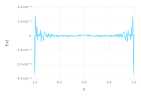

In [70]:
plot(x -> legendre_polyKahan(10,x) - legendre_poly(10,x),-1,1)

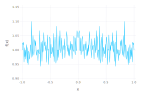

In [71]:
plot(x -> accuracy_test(legendre_polyKahan, 100,x)/accuracy_test(legendre_poly, 100,x), -1,1)

For the Bonnet recursion, what is the worst addition condition number? 

In [73]:
function add_cnd(a::Real,b::Real)
  (abs(a)+abs(b))/abs(a+b)
end

add_cnd (generic function with 1 method)

In [74]:
function add_cnd(a::Complex,b::Complex)
  max(add_cnd(real(a), real(b)), add_cnd(imag(a),imag(b)))
end

add_cnd (generic function with 2 methods)

In [75]:
function legendre_poly_cnd(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    worst = -Inf
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion                
            (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)/k)
            worst = max(worst, add_cnd((2*k - 1)*x*p1, - (k - 1)*p0))
        end
        worst
    end
end;

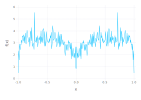

In [76]:
plot(x -> log10(legendre_poly_cnd(10^3,x)),-1,1)

Here we zoom in on the interval $[0.71885,0.7189]$

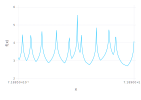

In [78]:
plot(x -> log10(legendre_poly_cnd(1000,x)), 0.71885,0.7189)

https://etna.math.kent.edu/vol.54.2021/pp323-332.dir/pp323-332.pdf

Here is a method that evaluates the Legendre polynomial using a power series in `(x-1)/2`.  The sum is
$$
  P_n(x)= \sum_{k=0}^n \binom{n}{k} \binom{n+k}{k} \left( \frac{x-1}{2} \right)^{\!k}.
$$
This can be summed from high to low power or from low to high power.

In [80]:
function LP_high_to_low(n::Integer, x::Number)
    w = (x-1)/2
    uno = one(x)
    s = uno
    for k in n : -1 :  1
        c = ((n-k+1)*(n+k))//k^2
        s = uno + c*w*s
    end
    s
end;         

In [81]:
function LP_low_to_high(n::Integer, x::Number)       
    w = (x-1)/2
    s = zero(x)
    z = one(x)
    ck = one(x)
    for k in 0 : n   
       s += ck*z
       ck *= (n-k)*(n+k+1)/(k+1)^2
       z *= w
    end
    s
end;  

Even for a modest degree and near 1, these methods differ by a fair amount.

In [83]:
LP_low_to_high(25, 0.75),LP_high_to_low(25, 0.75), legendre_poly(25, 0.75)

(0.06842766647710583, 0.06842766655582011, 0.0684276664756836)

But for inputs near -1, watch out! These methods disagree by a large amount!

In [85]:
LP_low_to_high(25, -0.75),LP_high_to_low(25, -0.75), legendre_poly(25, -0.75)

(5.9462890625, 4.04428214325455, -0.0684276664756836)

Let's look at the accuracy of this new method.  For degree 25, the accuracy is good for $x > 1$ and poor for inputs near -1. 

The two methods give similar accuracies. Both methods are inaccurate near -1.

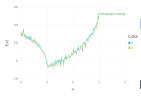

In [88]:
plot([x -> accuracy_test(LP_high_to_low, 25,x), x -> accuracy_test(LP_low_to_high, 25,x)],-2,2)

Why the inaccuracy? It's the result of an ill-conditioned sum. The only cures to an ill-conditioned sum are

- use a different algorithm
- use higher precision numbers

Compensated addition might help slightly, but it is _not_ a cure for an ill-conditioned sum.  Here we explicitly find the worst sum condition number and return it along with the sum.

In [90]:
function LP_low_to_high(n::Integer, x::Number)       
    w = (x-1)/2
    s = zero(x)
    z = one(x)
    ck = one(x)
    cnd = -Inf
    for k in 0 : n   
       cnd = max(cnd, (abs(s) + abs(ck*z))/abs(s+ck*z))
       s = s + ck*z
       ck *= (n-k)*(n+k+1)/(k+1)^2
       z *= w
    end
    s,cnd
end;

Here is a graph of the common log of the largest sum condition number on the interval $[-1,1]$.

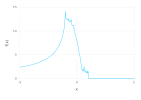

In [92]:
plot(x -> log10(LP_low_to_high(25,x)[2]), -5,5)

Amusingly, for higher degrees, the worst sum condition number is not so terrible

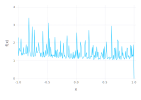

In [94]:
plot(x -> log10(LP_low_to_high(150,x)[2]), -1,1)

Another sum for the Legendre polynomials is
$$
   P_n(x)= \frac{1}{2^n} \sum_{k=0}^n \binom{n}{k}^{\!2} (x-1)^{n-k}(x+1)^k
$$
Possibly we could gain a bit of accuracy by using `fma` inside the loop. But that will fail for the complex case.

In [96]:
function legendre_poly_2(n::Integer, x::Number)
    w = (x+1)/(x-1)
    uno = one(x)
    s = uno
    for k in n : -1 : 1
        c = (n-k+1)/k
        s = uno + c^2*w*s
    end
    s * ((x-1)/2)^n
end;

This method is accurate away from $[-1,1]$ and poor in the interval $[-1,1]$.

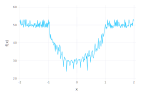

In [98]:
plot(x -> accuracy_test(legendre_poly_2,25,x),-2,2)

Finally, let's try a version of interval arithmetic.  There are several standard Julia packages that do interval arithmetic, but let's try writing our own code. 

Specifically, let us define $x  \in \mathrm{ball}(a,r)  \equiv |x - a| \leq \varepsilon r$, where $\varepsilon$ is the machine epsilon.  So
$x \in \mathrm{ball}(a,r_a)$ and $y \in \mathrm{ball}(b,r_b)$ implies $xy \in \mathrm{ball}(ab, |b| r_a + |a| r_b + \varepsilon r_a r_b)$. 
And for floating point multiplication $\otimes$, we have $x \otimes y \in \mathrm{ball}(ab, |ab| + |b| r_a + |a| r_b + \varepsilon r_a r_b)$.

For addition, we have $x \in \mathrm{ball}(a,r_a)$ and $y \in \mathrm{ball}(b,r_b)$ implies $x + y \in \mathrm{ball} 
\left (a+b, r_a + r_b \right)$. And for floating point addition $\oplus$, we have $ x \oplus y \in \mathrm{ball} \left (a+b, r_a + r_b + |x + y| \right)$.

In [100]:
struct ball{T<:Number}
    c::T
    r::T
      
    function ball(c::T, r::Number) where T<:Number
        new{T}(c, r)
    end

    function ball(c::T) where T<:Number
        new{T}(c, zero(c))
    end
end

In [101]:
function negate(x::ball)
    ball(-x.c, x.r)
end;

In [102]:
import Base: +, -, *, /

function *(x::ball{T}, y::ball{T}) where T<:AbstractFloat
   z = x.c * y.c
   ball(z, abs(z) + abs(x.c) * y.r + abs(y.c) * x.r)
end

function *(x::Number, y::ball{T}) where T<:AbstractFloat
      ball(convert(T,x)) * y
end

function *(x::ball{T}, y::Number) where T<:AbstractFloat
      x * ball(convert(T,y))
end

function +(x::ball{T}, y::ball{T}) where T<:AbstractFloat
    z = x.c + y.c
     ball(z, x.r + y.r + abs(z))
end

function +(x::Number, y::ball{T}) where T<:AbstractFloat
    ball(convert(T,x))+y
end
    
function +(x::ball{T}, y::Number) where T<:AbstractFloat
    x + ball(convert(T,y))
end

function -(x::ball{T}, y::ball{T}) where T<:AbstractFloat
  x + negate(y)
end
        
function -(x::ball{T}, y::Number) where T<:AbstractFloat
  x - ball(convert(T,y))
end
        
function -(x::Number, y::ball{T}) where T<:AbstractFloat
  ball(convert(T,x)) - y
end        

function /(x::ball{T}, y::ball{T}) where T<:AbstractFloat
    ball(x.c/y.c, (abs(y.c) * x.r + abs(x.c) * y.r) / (y.c)^2)
end

function /(x::ball{T}, y::Number) where T<:AbstractFloat
    x / ball(convert(T,y))
end
        
function /(x::Number, y::ball{T}) where T<:AbstractFloat
    ball(convert(T,x))/y
end

/ (generic function with 175 methods)

In [103]:
function LP(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be nonnegative; found $n"))
    
    p0 = ball(one(x))
    if n == 0 
        p0
    else
        p1 = ball(x)
        for k in 2:n # use the Bonnet recursion
             (p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)/k)
         end
       p1
    end
end

LP (generic function with 1 method)

Generally, the error is highly pessimistic, and it grows rather fast with the degree.

In [105]:
LP(2, 0.9)

ball{Float64}(0.7150000000000001, 2.43)

In [106]:
LP(4, 0.9)

ball{Float64}(0.2079375, 12.430125)

In [107]:
LP(8, 0.9)

ball{Float64}(-0.40968590351562517, 235.2249782120536)

In [108]:
LP(16, 0.9)

ball{Float64}(0.27833870133758787, 108942.1733905613)

In [109]:
LP(32, 0.9)

ball{Float64}(0.05695794106848601, 3.2325172447180775e10)

Herbie is an online tool that suggest alternative ways to numerically evaluate an expression to gain the best accuracy. For input, Herbie requires a range for each of the variables in the expression. For the ranges I choose, for the expression `((2*k - 1)*x*p1 - (k - 1)*p0)/k`,  Herbie suggested that `(((p1 * x) * 2.0) - ((p1 * x) / k)) + ((p0 / k) - p0)` was slightly more accurate.  Here is a "Herbie improved" method

In [111]:
function legendre_polyHerbie(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            (p0,p1) = (p1, (((p1 * x) * 2) - ((p1 * x) / k)) + ((p0 / k) - p0))
        end
        p1
    end
end;

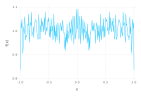

In [112]:
plot([x -> accuracy_test(legendre_polyHerbie, 128,x) / accuracy_test(legendre_poly, 128,x)],-1,1)

In [113]:
function PL2(q::Integer,x::Number)
   pk = x
   dk = x - one(x)
   if q==0
      one(x)
    else
       for k in 1 : q-1
         dk = ((2*k+1)*(x-1)*pk +k*dk)/(k+1)
         pk += dk
       end
       pk
    end
end

PL2 (generic function with 1 method)

The accuracy for this method is best near 1

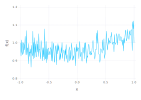

In [115]:
plot(x -> accuracy_test(PL2, 64, x)/accuracy_test(legendre_poly, 64, x),-1,1)


We can improve the accuracy near -1 by using the indentity $P_n(x) = (-1)^n P_n(-x)$

In [117]:
function PL2(q::Integer,x::Number)
  if real(x) < 0 
        (-1)^q * PL2(q, -x)
   else
      pk = x
      dk = x - one(x)
      if q==0
         one(x)
      else
         for k in 1 : q-1
            dk = ((2*k+1)*(x-1)*pk + k*dk)/(k+1)
            pk += dk
         end
         pk
      end
    end
end

PL2 (generic function with 1 method)

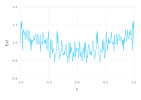

In [118]:
plot(x -> accuracy_test(PL2, 64, x)/accuracy_test(legendre_poly, 64, x),-1,1)

Here is a method that uses a running error to bound the rounding error.  Much like the interval method, the upper bound for the rounding error is wildly pessimistic, especially for large degree.

In [120]:
function legendre_polyRE(n::Integer, x::Number)
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        E0 = zero(x)
        E1 = zero(x)
        
        for k in 2:n # use the Bonnet recursion
                    
            pp1 = ((2*k - 1)*x*p1 - (k - 1)*p0)/k
            (E0,E1) = (E1, (2 - 1/k)*abs(x)*E1  + (1-1/k)*E0  + 3 *(2-1/k) * abs(x * p1) +  2*abs((1-1/k)*p0) + 2*abs(pp1))
            (p0,p1) = (p1, pp1)
         end
        if isnan(p1) throw(ArgumentError("Floating point overflow evaluating legendre_poly($n, $x)")) else p1,E1 end
    end
end;

In [121]:
legendre_polyRE(4,-0.98)

(0.8088606999999997, 46.324493833333335)

In [122]:
legendre_polyRE(16,-0.98)

(-0.3467790646575333, 855545.3955047231)

In [123]:
legendre_polyRE(32,-0.98)

(0.2626689222215517, 6.4505838067853e11)

In [124]:
legendre_polyRE(64,-0.98)

(0.20144978653915185, 5.1462114327906675e23)

Our last method comes from the _Handbook of Mathematical Functions with formulas, graphs, and mathematical tables_ by Abramowitz & Stegun page 789 (tenth printing, December 1972).  As written, the evaluation of the binomial coefficients is subject to integer overflow. We could, of course, use big integers to avoid this overflow. Likely, the required binomial coefficients should either be computed using quotients of gamma function, or possibly their evaluation should be done in a loop.

But we'll see that this method is not particularly accurate, so we won't put much effort into making the code beter.

In [126]:
function P_as(n::Integer, x::Number)
    z = x*x
    a = one(x)
    if isodd(n)   
        n = div(n-1,2)
        for m = n : -1 : 1
            a = 1 - (n-m+1)*(2*(n + m) + 1)*a*z/(m*(2*m+1))
        end
       ((-1)^n * (n+1)*x*binomial(2*n+1,n)/4^n) * a
     else
        n = div(n,2)
        for m = n : -1 : 1
           a = 1 - (n-m+1)*(2*(n + m) - 1)*a*z/(m*(2*m-1))
        end          
        ((-1)^n *  binomial(2*n,n) / 4^n) * a
    end
end ;    
        

Compared to `legendre_poly`, this method is slower

In [128]:
(n,x) = (55, 0.7);

In [129]:
@btime P_as(n,x)

  779.245 ns (1 allocation: 16 bytes)


0.10106243765172575

In [130]:
@btime legendre_poly(n,x)

  405.500 ns (1 allocation: 16 bytes)


0.10275456840877116

Particularly, near -1 and 1, the method isn't particularly accurate

In [132]:
P_as(n,x), legendre_poly(n,x), legendre_poly(n, convert(Float64, convert(Rational{BigInt}, x)))

(0.10106243765172575, 0.10275456840877116, 0.10275456840877116)

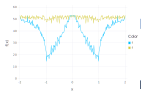

In [133]:
plot([x -> accuracy_test(P_as,32,x), x -> accuracy_test(legendre_poly, 32,x)],-2,2)

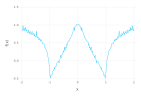

In [134]:
plot([x -> accuracy_test(P_as,62,x)/accuracy_test(legendre_poly, 62,x)],-2,2)

In [252]:
function legendre_poly_fma(n::Integer, x::Number)::Number
    n >= 0 || throw(ArgumentError("The first argument to legendre_poly must be a nonnegative integer; found $n"))
    p0 = one(x)
    if n == 0 
        one(x)
    else
        p1 = x
        for k in 2:n # use the Bonnet recursion
            #(p0,p1) = (p1, ((2*k - 1)*x*p1 - (k - 1)*p0)/k)
            (p0,p1) = (p1, fma((2-1/k)*x,p1, (1/k-1)*p0))
        end
        if isnan(p1) throw(ArgumentError("Floating point overflow evaluating legendre_poly($n, $x)")) else p1 end
    end
end;

In [254]:
legendre_poly_fma(5, 6//7)

-0.25957934194085824

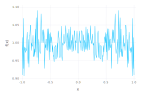

In [260]:
plot([x -> accuracy_test(legendre_poly_fma,32,x)/accuracy_test(legendre_poly,32,x)],-1,1)